In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from src.data_utils import split_data, aggregate_daily
from src.models import get_baseline_configs
import src.evaluation as evaluation

In [2]:
df = pd.read_parquet('data/final_df.parquet')
df.head()

,Date,Ticker,Ret_1d,Ret_21d,RSI_14d,Sector_Dispersion,Trend_Dist,Rel_Volume,Bull_Bear_Regime,Target_Regime_5d
0,2000-01-03,GE,-0.031176,0.110279,52.427610,0.039385,0.264959,1.200274,Bear,1.0
1,2000-01-03,CAT,0.032661,0.023408,58.447551,0.039385,-0.128287,1.432774,Bear,1.0
2,2000-01-03,RTX,-0.039221,0.061343,59.314112,0.039385,-0.014154,0.857426,Bear,1.0
3,2000-01-03,BRK-B,-0.036165,-0.047035,47.023795,0.016239,-0.168843,0.820248,Bear,1.0
4,2000-01-03,JPM,-0.063949,-0.081493,35.612084,0.016239,-0.080177,2.540854,Bear,1.0


In [3]:
feature_map = {
    'Ret_1d': 'Ret_1d',
    'Ret_21d': 'Ret_21d',
    'RSI_14d': 'RSI_14d',
    'Ret1d_Std_Dev': 'Sector_Dispersion',
    'Price_vs_MA200': 'Trend_Dist',
    'Rel_Volume': 'Rel_Volume',
}
feature_cols = list(feature_map.values())
(X_dev, y_dev), (X_test, y_test) = split_data(df, feature_cols)

In [4]:
tscv = TimeSeriesSplit(n_splits=3)
baseline_models, grids = get_baseline_configs()
best_estimators = {}

In [5]:
for name, pipe in baseline_models.items():
    print(f"\n{name}")

    # features are scaled internally within each fold
    search = GridSearchCV(pipe, grids[name], cv=tscv, scoring='roc_auc', n_jobs=-1)
    search.fit(X_dev[feature_cols], y_dev)
    
    best_model = search.best_estimator_

    raw_probs = best_model.predict_proba(X_dev[feature_cols])[:, 1]
    
    y_true_daily, y_probs_daily = aggregate_daily(df, X_dev.index, y_dev, raw_probs)
    train_auc = roc_auc_score(y_true_daily, y_probs_daily)

    print(f"Best Hyperparameters: {search.best_params_}")
    print(f"Train AUC: {train_auc:.4f}")
    best_estimators[name] = best_model


LogisticRegression
Best Hyperparameters: {'model__C': 0.001}
Train AUC: 0.8842

DecisionTree
Best Hyperparameters: {'model__criterion': 'gini', 'model__max_depth': 10, 'model__min_samples_leaf': 100}
Train AUC: 0.9322

RandomForest
Best Hyperparameters: {'model__max_depth': 10, 'model__min_samples_leaf': 50, 'model__n_estimators': 200}
Train AUC: 0.9308

LightGBM
[LightGBM] [Info] Number of positive: 54919, number of negative: 181861
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 236780, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Best Hyperparameters: {'model__learning_rate': 0.05, 'model__n_estimators': 

LogisticRegression Evaluation
Overall AUC: 0.8799
Onset Accuracy: 75.00%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      1183
         1.0       0.68      0.64      0.66       324

    accuracy                           0.86      1507
   macro avg       0.79      0.78      0.78      1507
weighted avg       0.85      0.86      0.85      1507


Regime Performance:
Bull Market Accuracy: 0.8656
Bull Market AUC: 0.6334
Bear Market Accuracy: 0.8019
Bear Market AUC: 0.6362


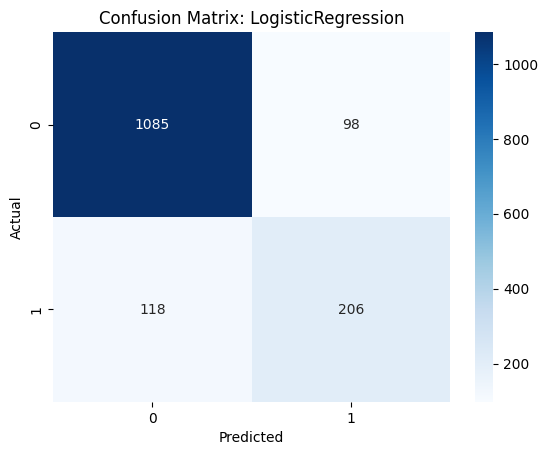

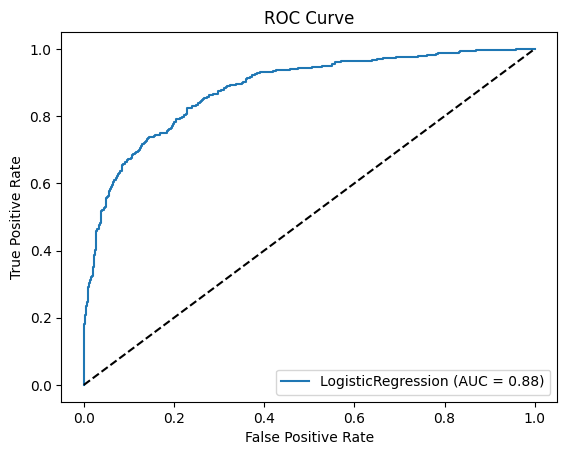

DecisionTree Evaluation
Overall AUC: 0.9210
Onset Accuracy: 75.00%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.90      0.91      1183
         1.0       0.67      0.76      0.71       324

    accuracy                           0.87      1507
   macro avg       0.80      0.83      0.81      1507
weighted avg       0.87      0.87      0.87      1507


Regime Performance:
Bull Market Accuracy: 0.8749
Bull Market AUC: 0.7246
Bear Market Accuracy: 0.8160
Bear Market AUC: 0.6159


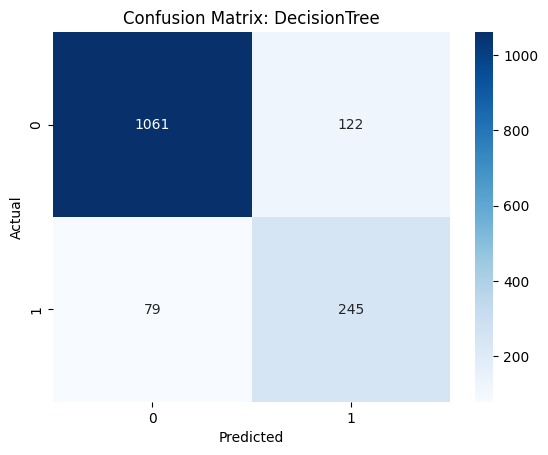

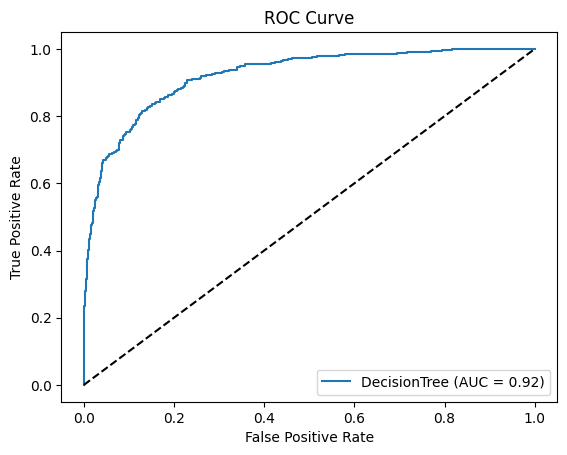

RandomForest Evaluation
Overall AUC: 0.9204
Onset Accuracy: 75.00%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91      1183
         1.0       0.68      0.73      0.70       324

    accuracy                           0.87      1507
   macro avg       0.80      0.82      0.81      1507
weighted avg       0.87      0.87      0.87      1507


Regime Performance:
Bull Market Accuracy: 0.8780
Bull Market AUC: 0.7103
Bear Market Accuracy: 0.8066
Bear Market AUC: 0.6098


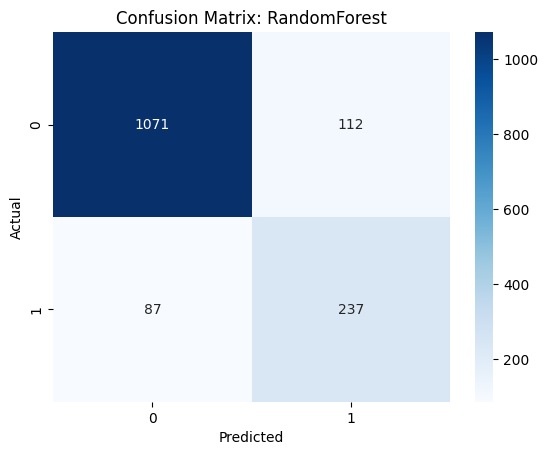

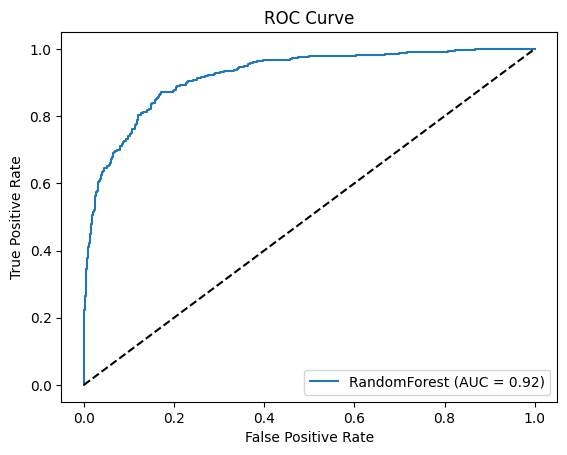

LightGBM Evaluation
Overall AUC: 0.9234
Onset Accuracy: 83.33%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91      1183
         1.0       0.66      0.78      0.71       324

    accuracy                           0.87      1507
   macro avg       0.80      0.84      0.81      1507
weighted avg       0.88      0.87      0.87      1507


Regime Performance:
Bull Market Accuracy: 0.8780
Bull Market AUC: 0.7532
Bear Market Accuracy: 0.7925
Bear Market AUC: 0.5785


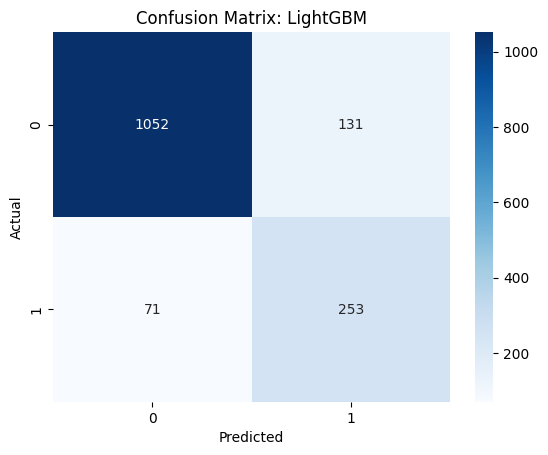

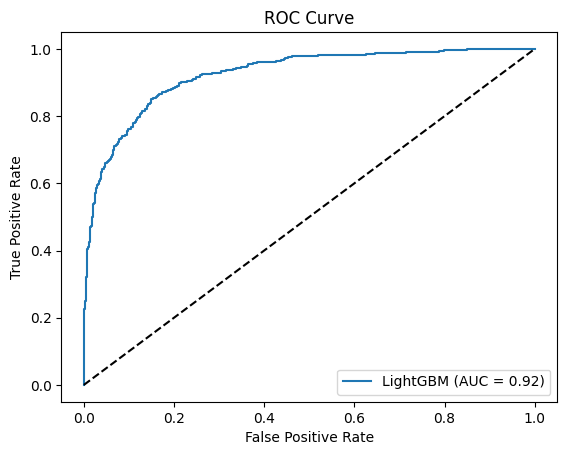

XGBoost Evaluation
Overall AUC: 0.9231
Onset Accuracy: 75.00%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92      1183
         1.0       0.68      0.79      0.73       324

    accuracy                           0.87      1507
   macro avg       0.81      0.84      0.82      1507
weighted avg       0.88      0.87      0.88      1507


Regime Performance:
Bull Market Accuracy: 0.8849
Bull Market AUC: 0.7599
Bear Market Accuracy: 0.8019
Bear Market AUC: 0.5920


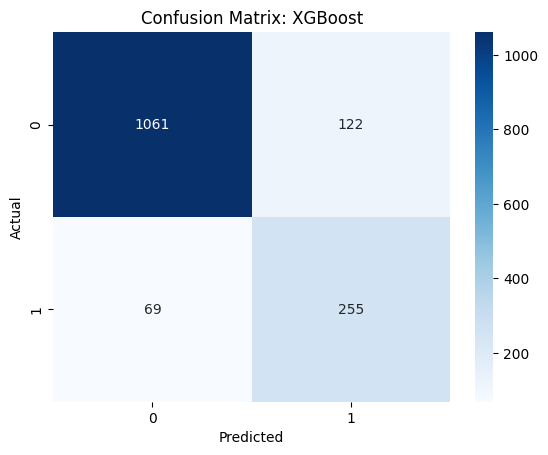

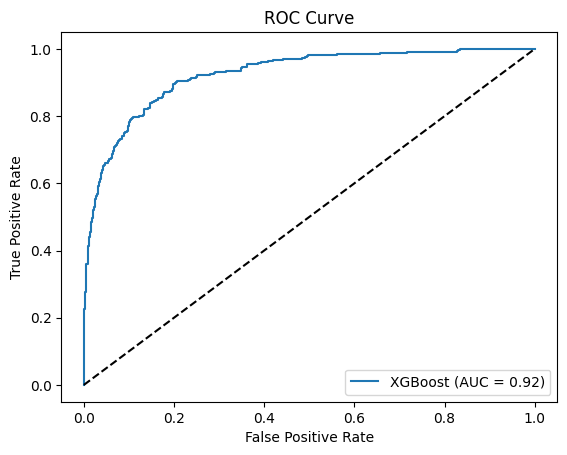

In [6]:
test_df_daily = df.loc[X_test.index].groupby('Date').first().sort_index()

for name, model in best_estimators.items():
    raw_test_probs = model.predict_proba(X_test[feature_cols])[:, 1]
    
    y_true_daily, y_probs_daily = aggregate_daily(df, X_test.index, y_test, raw_test_probs)
    
    results = evaluation.evaluate_model(name, y_true_daily, y_probs_daily, test_df_daily)
    
    evaluation.plot_confusion_matrix(results['basic'], name)
    evaluation.plot_roc_curve(y_true_daily, y_probs_daily, name)

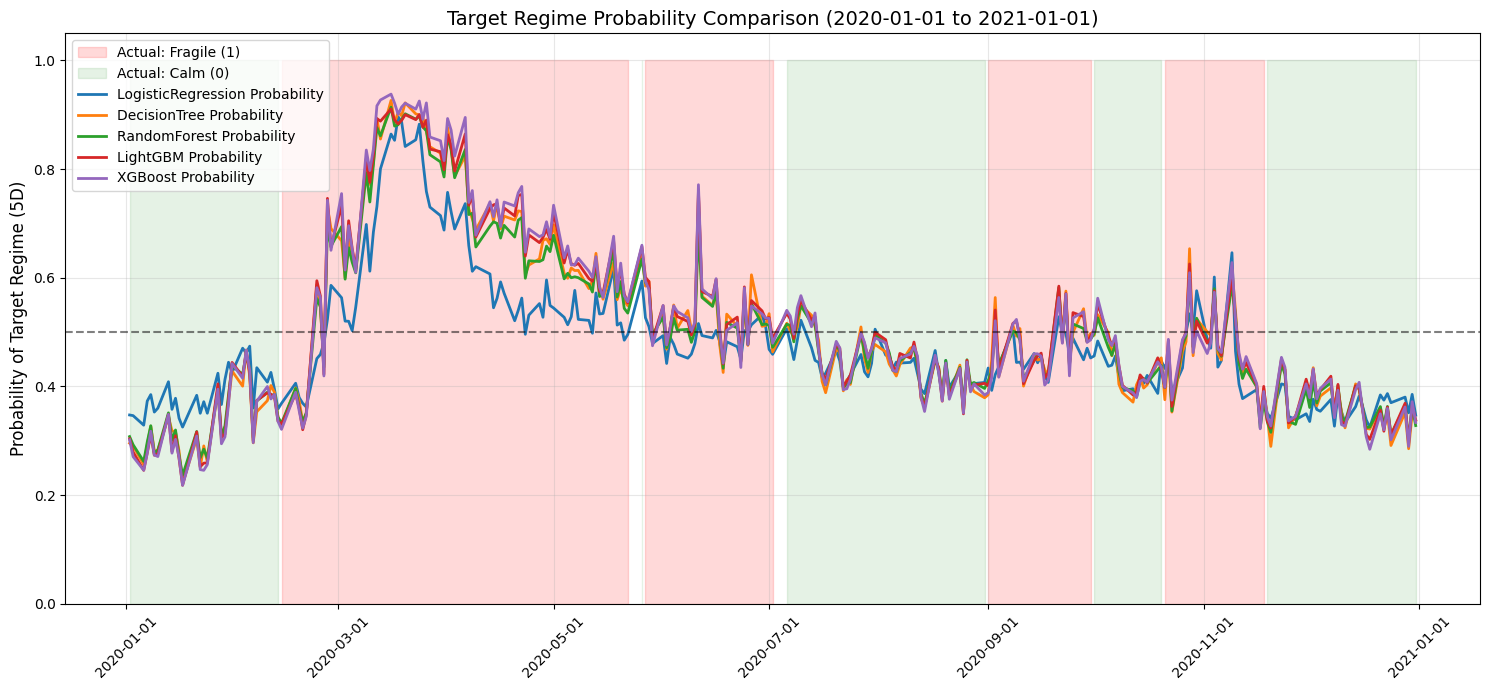

In [7]:
comparison_probs = {}

baseline_models_to_compare = best_estimators

test_indices = X_test.index
y_test_labels = y_test

y_true_daily_ref = None
daily_index_ref = pd.DatetimeIndex(df.loc[test_indices, 'Date'].unique()).sort_values()

for name, model in baseline_models_to_compare.items():
    probs = model.predict_proba(X_test[feature_cols])[:, 1]
    
    y_true_daily, y_probs_daily = aggregate_daily(df, test_indices, y_test_labels, probs)
    
    comparison_probs[name] = y_probs_daily
    y_true_daily_ref = y_true_daily

evaluation.plot_regime_comparison(
    comparison_probs, 
    y_true_daily_ref, 
    daily_index_ref, 
    start_date='2020-01-01', 
    end_date='2021-01-01'
)

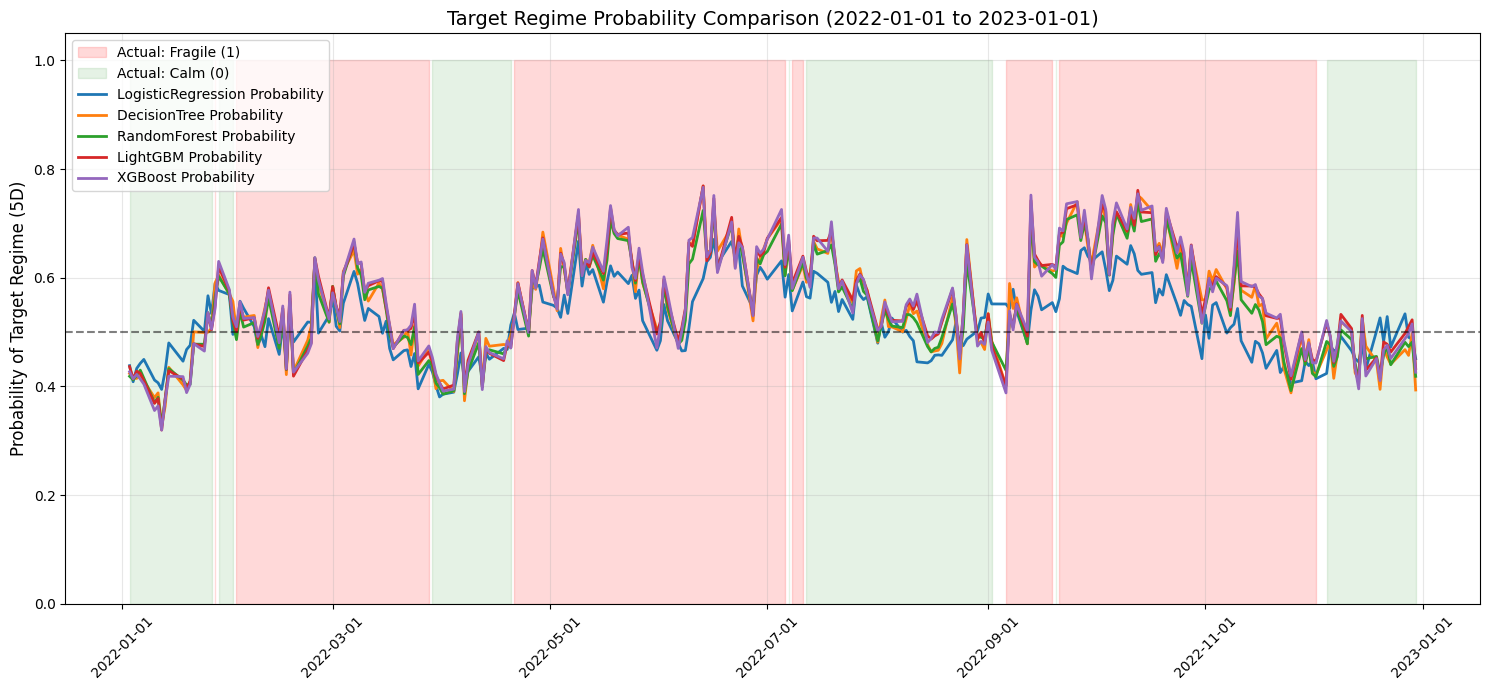

In [8]:
evaluation.plot_regime_comparison(
    comparison_probs, 
    y_true_daily_ref, 
    daily_index_ref, 
    start_date='2022-01-01', 
    end_date='2023-01-01'
)

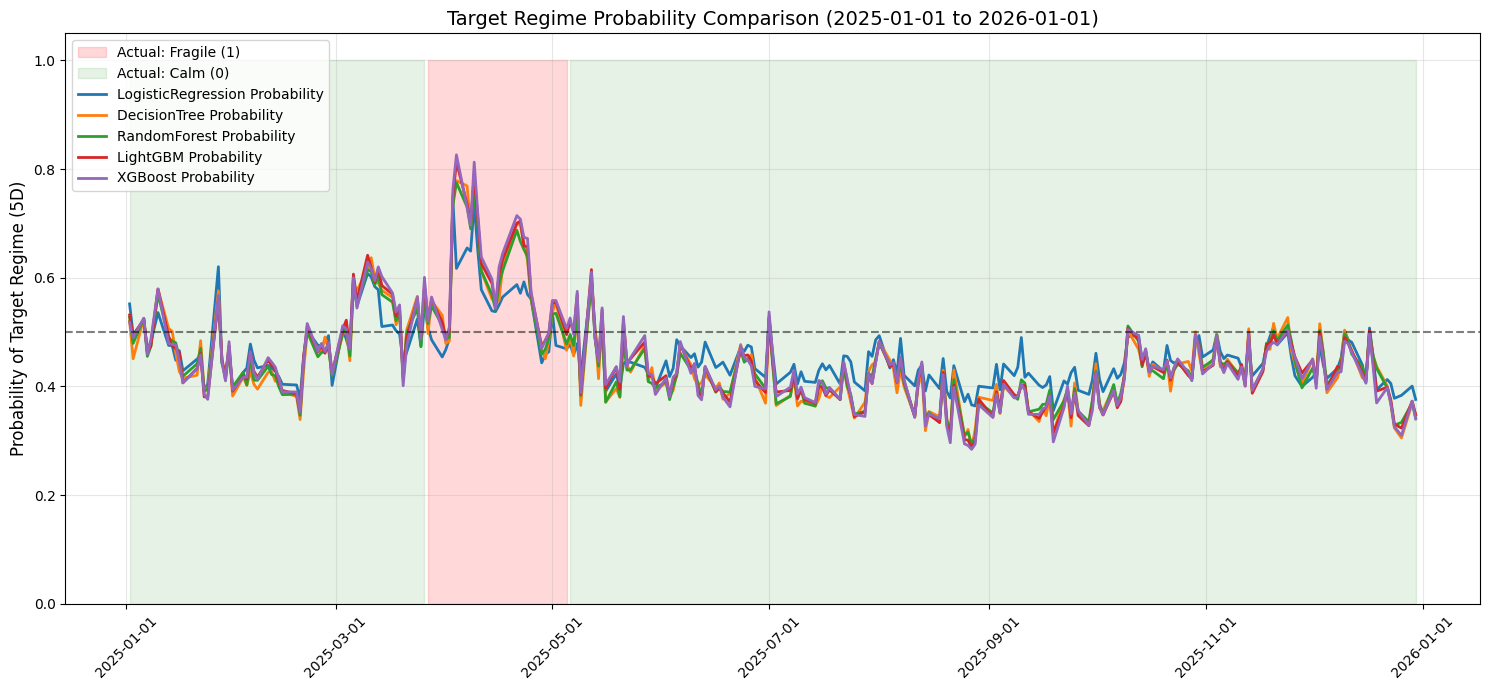

In [9]:
evaluation.plot_regime_comparison(
    comparison_probs, 
    y_true_daily_ref, 
    daily_index_ref, 
    start_date='2025-01-01', 
    end_date='2026-01-01'
)